In [59]:
import yfinance as yf

In [104]:
stock = yf.Ticker("AAPL")
stock = stock.history(period="max")
del stock['Dividends']
del stock['Stock Splits']

In [105]:
stock

,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12 00:00:00-05:00,0.099584,0.100017,0.099584,0.099584,469033600
1980-12-15 00:00:00-05:00,0.094821,0.094821,0.094388,0.094388,175884800
1980-12-16 00:00:00-05:00,0.087893,0.087893,0.087461,0.087461,105728000
1980-12-17 00:00:00-05:00,0.089625,0.090058,0.089625,0.089625,86441600
1980-12-18 00:00:00-05:00,0.092224,0.092657,0.092224,0.092224,73449600
...,...,...,...,...,...
2023-08-07 00:00:00-04:00,182.130005,183.130005,177.350006,178.850006,97576100
2023-08-08 00:00:00-04:00,179.690002,180.270004,177.580002,179.800003,67823000
2023-08-09 00:00:00-04:00,180.869995,180.929993,177.009995,178.190002,60378500


In [106]:
stock['Tomorrow'] = stock['Close'].shift(-1)

In [107]:
stock

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1980-12-12 00:00:00-05:00,0.099584,0.100017,0.099584,0.099584,469033600,0.094388
1980-12-15 00:00:00-05:00,0.094821,0.094821,0.094388,0.094388,175884800,0.087461
1980-12-16 00:00:00-05:00,0.087893,0.087893,0.087461,0.087461,105728000,0.089625
1980-12-17 00:00:00-05:00,0.089625,0.090058,0.089625,0.089625,86441600,0.092224
1980-12-18 00:00:00-05:00,0.092224,0.092657,0.092224,0.092224,73449600,0.097852
...,...,...,...,...,...,...
2023-08-07 00:00:00-04:00,182.130005,183.130005,177.350006,178.850006,97576100,179.800003
2023-08-08 00:00:00-04:00,179.690002,180.270004,177.580002,179.800003,67823000,178.190002
2023-08-09 00:00:00-04:00,180.869995,180.929993,177.009995,178.190002,60378500,177.970001


In [108]:
stock['Target'] = (stock['Tomorrow'] >  stock['Close']).astype(int)

In [109]:
stock = stock.loc['2013-01-01':].copy()

In [66]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [67]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = stock.iloc[:-100]
test = stock.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [68]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6

<Axes: xlabel='Date'>

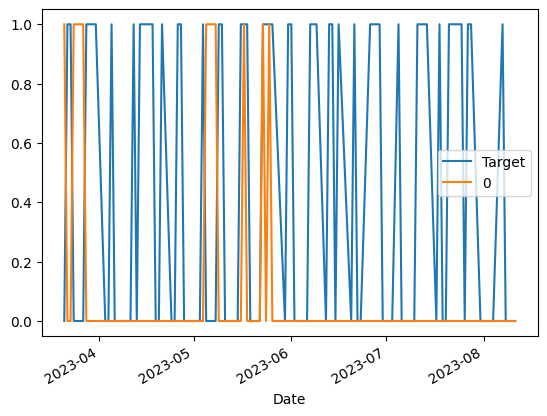

In [47]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [48]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [35]:
predictions = backtest(stock, model, predictors)


In [36]:
predictions["Predictions"].value_counts()


Predictions
0    4109
1    1858
Name: count, dtype: int64

In [37]:
predictions

,Target,Predictions
Date,,
1999-11-22 00:00:00-05:00,1,1
1999-11-23 00:00:00-05:00,1,1
1999-11-24 00:00:00-05:00,1,1
1999-11-26 00:00:00-05:00,0,0
1999-11-29 00:00:00-05:00,1,1
...,...,...
2023-08-04 00:00:00-04:00,0,0
2023-08-07 00:00:00-04:00,1,0
2023-08-08 00:00:00-04:00,0,0


In [114]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load your stock data into a pandas DataFrame
# Replace 'your_data.csv' with your actual data file

data =stock
# Define features and target
features = ["Close","Volume",  "Open", "High", "Low"]
target = ['Target']

# Prepare the data
X = data[features].values
y = data[target].values

# Normalize the features
scaler = StandardScaler()
X_scaled = X

# Set the proportion of data for training
train_proportion = 0.8  # 80% for training

# Calculate the split index
split_index = int(len(X_scaled) * train_proportion)

# Split the data into training and testing sets
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

 
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
model = keras.Sequential([
    keras.layers.LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

# Make predictions
predictions = model.predict(X_test)
predictions_binary = np.round(predictions)  # Convert probabilities to binary predictions

# Calculate accuracy of binary predictions
binary_accuracy = accuracy_score(y_test, predictions_binary)
print(f"Binary accuracy: {binary_accuracy:.4f}")


Epoch 1/50
67/67 [==============================] - 1s 1ms/step - loss: 910497.0625 - accuracy: 0.5042
Epoch 2/50
67/67 [==============================] - 0s 1ms/step - loss: 275768.8438 - accuracy: 0.5005
Epoch 3/50
67/67 [==============================] - 0s 1ms/step - loss: 37139.8789 - accuracy: 0.5080
Epoch 4/50
67/67 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.5267
Epoch 5/50
67/67 [==============================] - 0s 1ms/step - loss: 0.6918 - accuracy: 0.5267
Epoch 6/50
67/67 [==============================] - 0s 1ms/step - loss: 0.6916 - accuracy: 0.5267
Epoch 7/50
67/67 [==============================] - 0s 1ms/step - loss: 0.6916 - accuracy: 0.5267
Epoch 8/50
67/67 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.5267
Epoch 9/50
67/67 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5267
Epoch 10/50
67/67 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.5267
Epoch

In [115]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load your stock data into a DataFrame
# Assuming 'data' is your DataFrame containing stock data
# Make sure the data is sorted by datetime

# Define features and target
features = ["Close", "Volume", "Open", "High", "Low"]
target = ['Target']

# Preprocess the data
scaler = MinMaxScaler()
data[features + target] = scaler.fit_transform(data[features + target])

# Define sequence length (number of time steps to consider)
sequence_length = 10

# Prepare sequences for input
def prepare_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[features].values[i:i+sequence_length])
        targets.append(data[target].values[i+sequence_length])
    return np.array(sequences), np.array(targets)

sequences, targets = prepare_sequences(data, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Build the GRU model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, input_shape=(sequence_length, len(features)), return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Make predictions
predicted_values = model.predict(X_test)

# Inverse transform predictions and targets to get original scale
predicted_values = scaler.inverse_transform(np.concatenate([X_test[:, -1, :-1], predicted_values], axis=1))[:, -1]
actual_values = scaler.inverse_transform(np.concatenate([X_test[:, -1, :-1], y_test], axis=1))[:, -1]

# Calculate RMSE or other relevant metrics
rmse = np.sqrt(np.mean((predicted_values - actual_values)**2))
print("Root Mean Squared Error:", rmse)


Epoch 1/50
34/34 [==============================] - 2s 13ms/step - loss: 0.2895 - val_loss: 0.2515
Epoch 2/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2550 - val_loss: 0.2505
Epoch 3/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2548 - val_loss: 0.2632
Epoch 4/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2527 - val_loss: 0.2493
Epoch 5/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2516 - val_loss: 0.2511
Epoch 6/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2506 - val_loss: 0.2493
Epoch 7/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2504 - val_loss: 0.2505
Epoch 8/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2506 - val_loss: 0.2491
Epoch 9/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2504 - val_loss: 0.2512
Epoch 10/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2502 - val_loss: 0.2512
Epoch 11/50
34/34 

ValueError: operands could not be broadcast together with shapes (533,5) (6,) (533,5) 